# Import Library

In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports
from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2
from pycocotools.coco import COCO

# Other Imports
from tqdm.notebook import tqdm

LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]

# 1. Convert json to dataframe

In [7]:
coco = COCO('D:\\AI-BOOSTCAMP-7TH\\level2-objectdetection-cv-18\\dataset\\train.json')

train_df = pd.DataFrame()

image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
for image_id in coco.getImgIds():
        
    image_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_info['id'])
    anns = coco.loadAnns(ann_ids)
        
    file_name = image_info['file_name']
        
    for ann in anns:
        image_ids.append(file_name)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

train_df['image_id'] = image_ids
train_df['class_name'] = class_name
train_df['class_id'] = class_id
train_df['x_min'] = x_min
train_df['y_min'] = y_min
train_df['x_max'] = x_max
train_df['y_max'] = y_max

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


# 2. EDA

## 2-1. Annotation Per Images

In [8]:
# 한 이미지에 몇 개의 Bounding box가 있는지, 그 분포를 나타낸 결과입니다.
fig = px.histogram(train_df.image_id.value_counts(), 
                   log_y=True, color_discrete_sequence=['indianred'], opacity=0.7,
                   labels={"value":"Number of Annotations Per Image"},
                   title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER IMAGE   " \
                         "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )
fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique Images</b>",
                  yaxis_title="<b>Count of All Object Annotations</b>",)
fig.show()

## 2-2. Unique Class Per Image

In [9]:
# 한 이미지의 몇 개의 unique한 class가 있는지, 그 분포를 나타낸 결과입니다.
fig = px.histogram(train_df.groupby('image_id')["class_id"].unique().apply(lambda x: len(x)), 
             log_y=True, color_discrete_sequence=['skyblue'], opacity=0.7,
             labels={"value":"Number of Unique class"},
             title="<b>DISTRIBUTION OF # OF Unique Class PER IMAGE   " \
                   "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )
fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique CLASS</b>",
                  yaxis_title="<b>Count of Unique IMAGE</b>",)
fig.show()

## 2-3. Annotations Per Class

In [10]:
# 각 Class 당 몇 개의 Annotation, 즉 bbox가 있는지, 그 분포를 나타낸 결과입니다.
fig = px.bar(train_df.class_name.value_counts().sort_index(), 
             color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS, log_y=True,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class</b>",)
fig.update_layout(legend_title=None,
                  xaxis_title="",
                  yaxis_title="<b>Annotations Per Class</b>")

fig.show()

## 2-4. Object heatmap

  0%|          | 0/23144 [00:00<?, ?it/s]

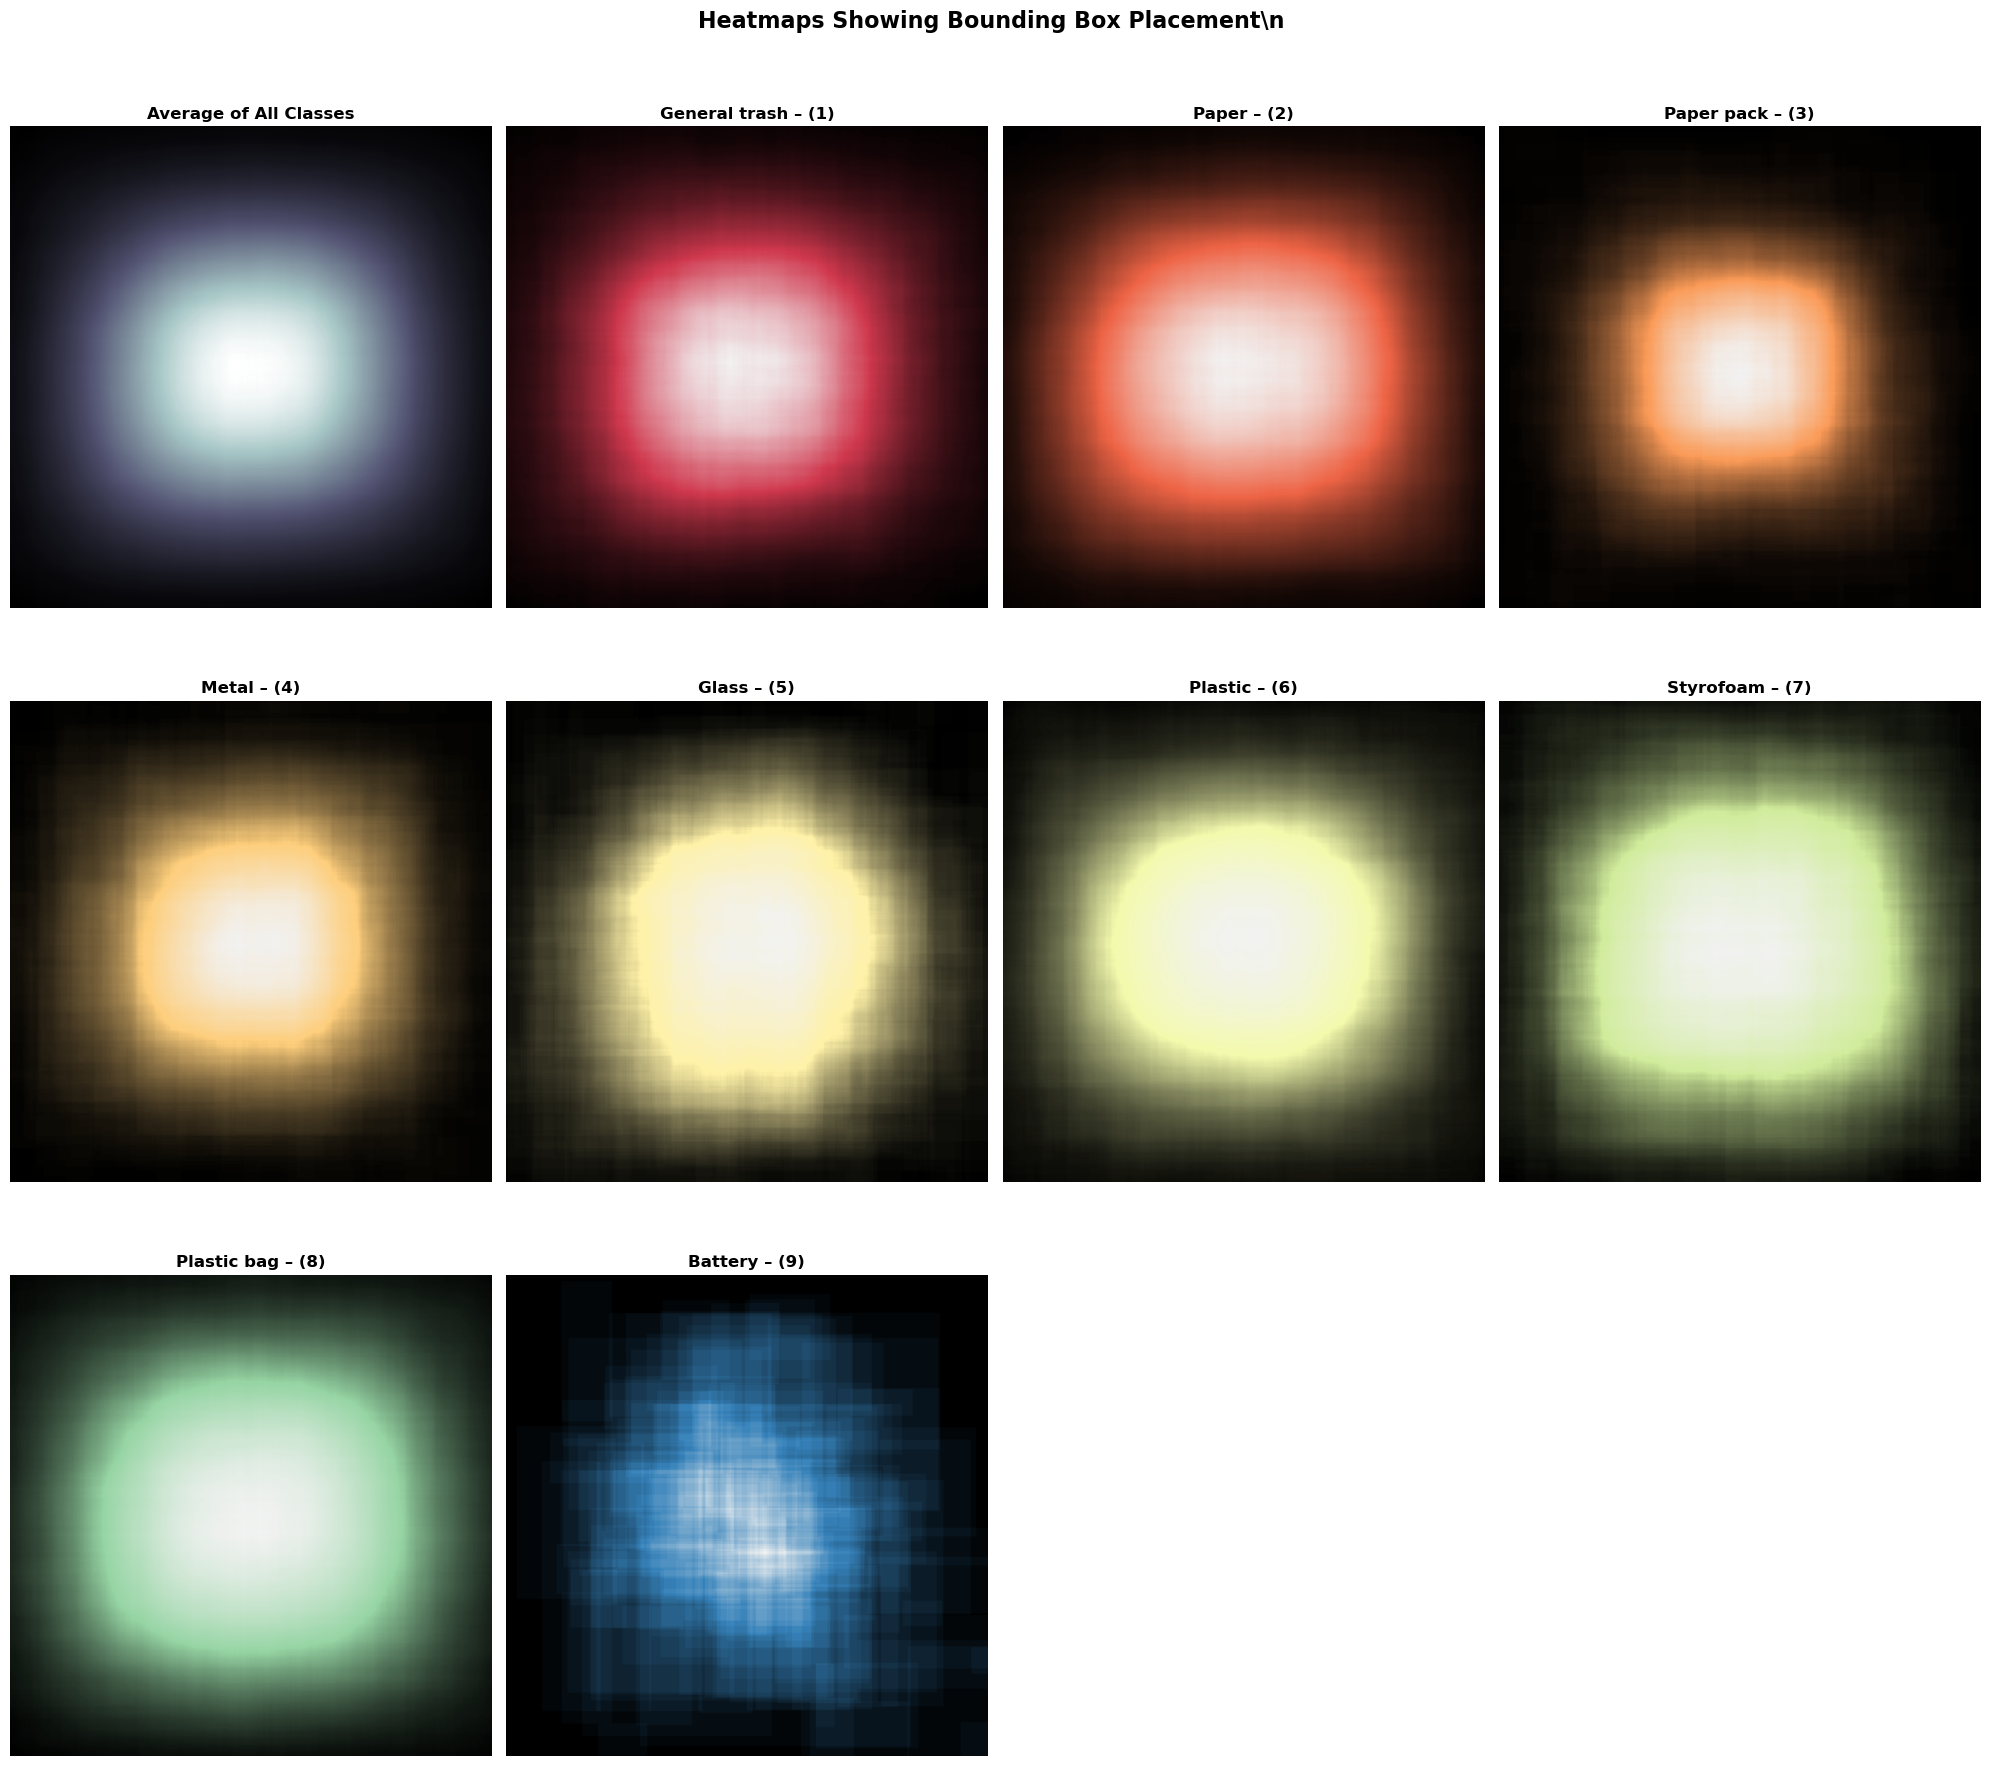

In [8]:
# 이미지에서 bbox가 주로 어디에 위치하는지를 알아보기 위한 코드입니다.
bbox_df = pd.DataFrame()
bbox_df['class_id'] = train_df['class_id'].values
bbox_df['class_name'] = train_df['class_name'].values
bbox_df['x_min'] = train_df['x_min'].values / 1024
bbox_df['x_max'] = train_df['x_max'].values / 1024
bbox_df['y_min'] = train_df['y_min'].values / 1024
bbox_df['y_max'] = train_df['y_max'].values / 1024
bbox_df['frac_x_min'] = train_df['x_min'].values / 1024
bbox_df['frac_x_max'] = train_df['x_max'].values / 1024
bbox_df['frac_y_min'] = train_df['y_min'].values / 1024
bbox_df['frac_y_max'] = train_df['y_max'].values / 1024

ave_src_img_height = 1024
ave_src_img_width = 1024

# DEFAULT
HEATMAP_SIZE = (ave_src_img_height, ave_src_img_width, 14)

# Initialize
heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bbox_np = bbox_df[["class_id", "frac_x_min", "frac_x_max", "frac_y_min", "frac_y_max"]].to_numpy()
bbox_np[:, 1:3] *= ave_src_img_width
bbox_np[:, 3:5] *= ave_src_img_height
bbox_np = np.floor(bbox_np).astype(np.int16)

# Color map stuff
custom_cmaps = [
    matplotlib.colors.LinearSegmentedColormap.from_list(
        colors=[(0.,0.,0.), c, (0.95,0.95,0.95)], 
        name=f"custom_{i}") for i,c in enumerate(sns.color_palette("Spectral", 10))
]
custom_cmaps.pop(8) # Remove No-Finding

for row in tqdm(bbox_np, total=bbox_np.shape[0]):
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1
    
fig = plt.figure(figsize=(20,25))
plt.suptitle("Heatmaps Showing Bounding Box Placement\\n ", fontweight="bold", fontsize=16)
for i in range(10):
    plt.subplot(4, 4, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"Average of All Classes", fontweight="bold")
    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"{classes[i-1]} – ({i})", fontweight="bold")
        
    plt.axis(False)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

## 2-5. Distribution of bbox area

In [10]:
# 각 Class 별 bounding box의 크기 분포입니다.
# Update bbox dataframe to make this easier
bbox_df["frac_bbox_area"] = (bbox_df["frac_x_max"]-bbox_df["frac_x_min"])*(bbox_df["frac_y_max"]-bbox_df["frac_y_min"])
# bbox_df["class_id_as_str"] = bbox_df["class_id"].map(classes)
display(bbox_df.head())

fig = px.box(bbox_df.sort_values(by="class_name"), x="class_name", y="frac_bbox_area", color="class_name", 
             color_discrete_sequence=LABEL_COLORS_WOUT_NO_FINDING, notched=True,
             labels={"class_name":"Class Name", "frac_bbox_area":"BBox Area (%)"},
             title="<b>DISTRIBUTION OF BBOX AREAS AS % OF SOURCE IMAGE AREA   " \
                   "<i><sub>(Some Upper Outliers Excluded For Better Visualization)</sub></i></b>")

fig.update_layout(showlegend=True,
                  yaxis_range=[-0.025,0.4],
                  legend_title_text=None,
                  xaxis_title="",
                  yaxis_title="<b>Bounding Box Area %</b>",)
fig.show()

,class_id,class_name,x_min,x_max,y_min,y_max,frac_x_min,frac_x_max,frac_y_min,frac_y_max,frac_bbox_area
0,0,General trash,0.192969,0.727930,0.189160,0.647852,0.192969,0.727930,0.189160,0.647852,0.245382
1,3,Metal,0.000000,0.056250,0.397852,0.574219,0.000000,0.056250,0.397852,0.574219,0.009921
2,7,Plastic bag,0.000000,0.141211,0.444922,0.622266,0.000000,0.141211,0.444922,0.622266,0.025043
3,4,Glass,0.705371,0.973242,0.306055,0.552051,0.705371,0.973242,0.306055,0.552051,0.065895
4,5,Plastic,0.344922,0.573145,0.655273,0.756250,0.344922,0.573145,0.655273,0.756250,0.023045


## 2-6. Aspect Ratio for bounding boxes by class

In [25]:
# 각 Class 별 bounding box의 aspect ratio 값입니다. 이를 활용하여 anchor generator의 aspect ratio 비율을 조절해볼 수 있습니다.
# Aspect Ratio is Calculated as Width/Height
bbox_df["aspect_ratio"] = (bbox_df["x_max"]-bbox_df["x_min"])/(bbox_df["y_max"]-bbox_df["y_min"])

# Display average means for each class_id so we can examine the newly created Aspect Ratio Column
numeric_columns = bbox_df.select_dtypes(include=['float64', 'int64']).columns
avg_values = bbox_df.groupby("class_id")[numeric_columns].mean()
display(avg_values)

# Generate the bar plot
fig = px.bar(x=classes, y=avg_values["aspect_ratio"], 
             color=classes, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS_WOUT_NO_FINDING, 
             labels={"x":"Class Name", "y":"Aspect Ratio (W/H)"},
             title="<b>Aspect Ratios For Bounding Boxes By Class</b>",)
fig.update_layout(
                  yaxis_title="<b>Aspect Ratio (W/H)</b>",
                  xaxis_title=None,
                  legend_title_text=None)
fig.add_hline(y=1, line_width=2, line_dash="dot", 
              annotation_font_size=10, 
              annotation_text="<b>SQUARE ASPECT RATIO</b>", 
              annotation_position="bottom left", 
              annotation_font_color="black")
fig.add_hrect(y0=0, y1=0.5, line_width=0, fillcolor="red", opacity=0.125,
              annotation_text="<b>>2:1 VERTICAL RECTANGLE REGION</b>", 
              annotation_position="bottom right", 
              annotation_font_size=10,
              annotation_font_color="red")
fig.add_hrect(y0=2, y1=3.5, line_width=0, fillcolor="green", opacity=0.04,
              annotation_text="<b>>2:1 HORIZONTAL RECTANGLE REGION</b>", 
              annotation_position="top right", 
              annotation_font_size=10,
              annotation_font_color="green")
fig.show()

,class_id,x_min,x_max,y_min,y_max,frac_x_min,frac_x_max,frac_y_min,frac_y_max,frac_bbox_area,aspect_ratio
class_id,,,,,,,,,,,
0,0.0,0.383549,0.604483,0.394808,0.605228,0.383549,0.604483,0.394808,0.605228,0.075207,1.433186
1,1.0,0.375895,0.633562,0.375408,0.606554,0.375895,0.633562,0.375408,0.606554,0.087780,1.391648
2,2.0,0.378863,0.618020,0.408042,0.622968,0.378863,0.618020,0.408042,0.622968,0.072590,1.296333
3,3.0,0.387037,0.632183,0.368833,0.620011,0.387037,0.632183,0.368833,0.620011,0.087399,1.239462
4,4.0,0.401057,0.602315,0.388950,0.654449,0.401057,0.602315,0.388950,0.654449,0.066126,1.043987
5,5.0,0.391260,0.625025,0.386217,0.611491,0.391260,0.625025,0.386217,0.611491,0.077239,1.288092
6,6.0,0.352261,0.644397,0.368552,0.614946,0.352261,0.644397,0.368552,0.614946,0.093069,1.474087
7,7.0,0.368910,0.637833,0.341409,0.635559,0.368910,0.637833,0.341409,0.635559,0.105245,1.106761
8,8.0,0.401370,0.624880,0.422020,0.631976,0.401370,0.624880,0.422020,0.631976,0.048075,1.428327


In [1]:
# 각 Class 별 bounding box의 aspect ratio 값입니다. 이를 활용하여 anchor generator의 aspect ratio 비율을 조절해볼 수 있습니다.
# Generate the bar plot
fig = px.bar(x=['nms', 'soft_nms', 'non_maximum_weighted', 'weighted_boxes'], y=[0.3654, 0.3450, 0.3669, 0.3641], 
             color=classes, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS_WOUT_NO_FINDING, 
             labels={"x":"Class Name", "y":"Public Score"},
             title="<b>Aspect Ratios For Bounding Boxes By Class</b>",)

fig.show()

NameError: name 'bbox_df' is not defined